# Initial SetUp

In [1]:
!pip install super-gradients==3.1.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

  Using cached pyparsing-2.4.5-py2.py3-none-any.whl (67 kB)


  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.7
    Uninstalling pyparsing-2.4.7:
ERROR: Could not install packages due to an OSError: Cannot move the non-empty directory '/Users/macbook/anaconda3/lib/python3.10/site-packages/pyparsing-2.4.7.dist-info/': Lacking write permission to '/Users/macbook/anaconda3/lib/python3.10/site-packages/pyparsing-2.4.7.dist-info/'.



In [2]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

2023-05-17 23:01:34.871289: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[2023-05-17 23:01:37] INFO - utils.py - NumExpr defaulting to 8 threads.


In [3]:
# Get pre trained weights

# model = models.get(Models.YOLO_NAS_L, pretrained_weights="coco")

In [4]:
# Install SAM
#!pip install git+https://github.com/facebookresearch/segment-anything.git

In [5]:
import torch
torch.__version__

'1.13.1'

In [6]:
("cuda" if torch.cuda.is_available() else "cpu")

'cpu'

# SAM SETUP

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

Helper Function

In [8]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

# Automatic mask generation
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

# Load Ip Image

In [9]:
image = cv2.imread('images/pic.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

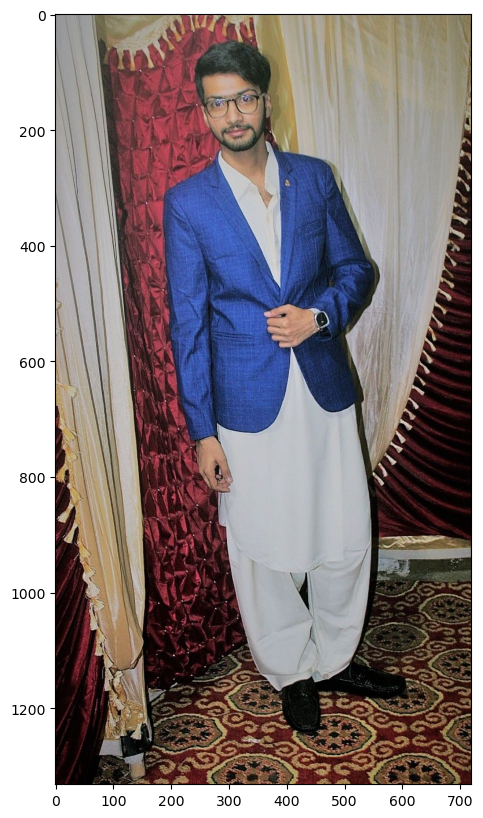

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

# YOLO_NAS

In [11]:
from super_gradients.training import models

yolo_nas_l = models.get("yolo_nas_l", pretrained_weights="coco")

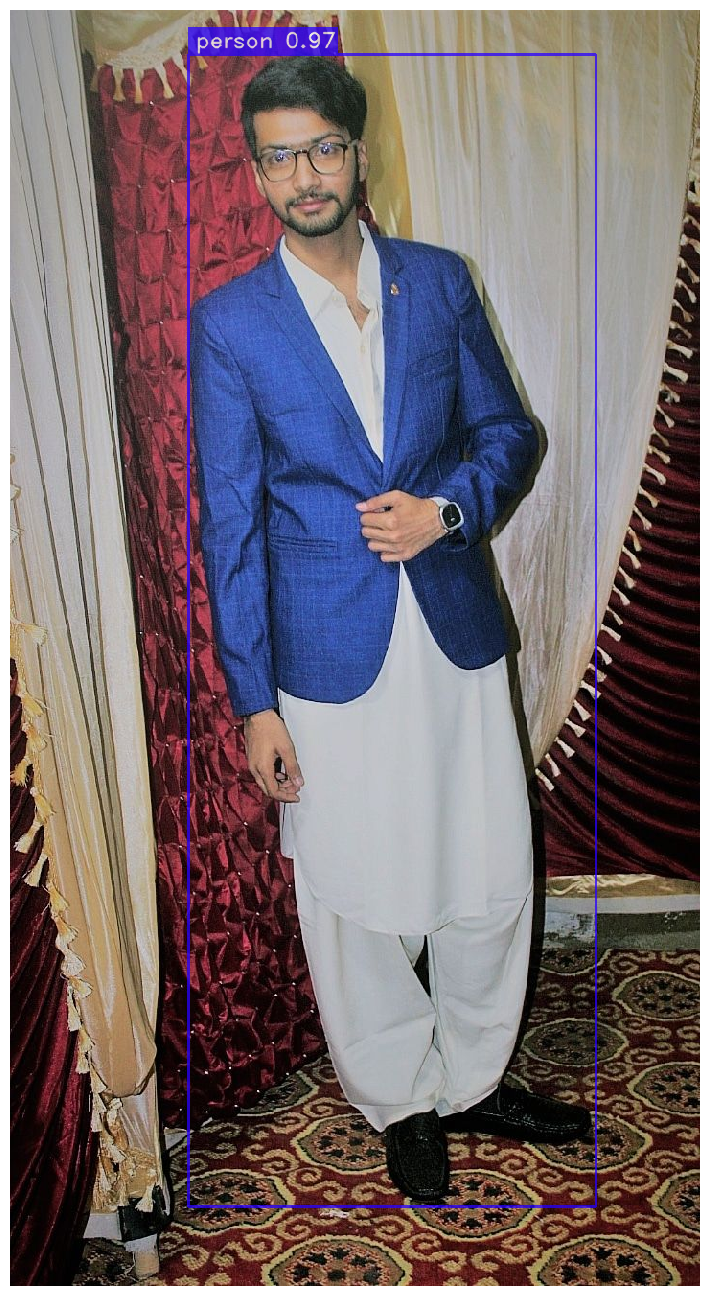

In [12]:
yolo_nas_l.predict(image, conf=0.25).show()

Save to output folder

In [13]:
conf_threshold = 0.25
detection_pred = yolo_nas_l.predict(image, conf = conf_threshold)
detection = detection_pred.save('YoloNAS_SAM/output')

# SAM

In [14]:
from segment_anything import sam_model_registry, SamPredictor
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)


In [15]:
predictor.set_image(image)
masks = mask_generator.generate(image)

In [16]:
print(len(masks))
print(masks[0].keys())

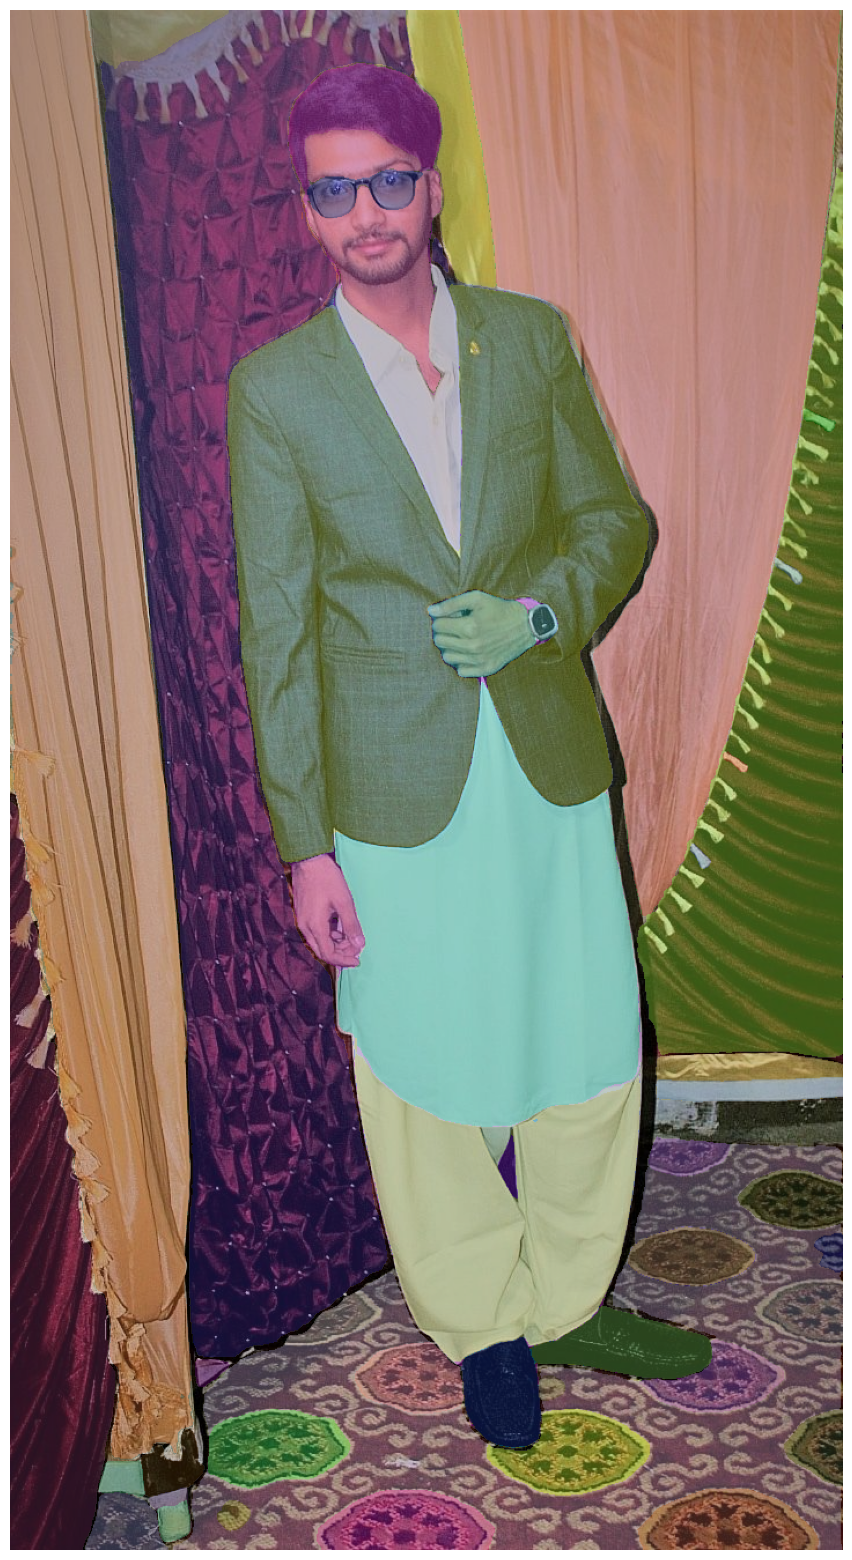

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

# YOLO_NAS + SAM = For segmenting and detecting specific class

Steps:
1. Object detection using NAS.
2.Provide Bounding Box Coordinates to SAM.
3. SAM provides mask.


In [18]:
from super_gradients.training import models

model_nas = models.get("yolo_nas_l", pretrained_weights="coco")
conf_threshold = 0.25


In [19]:
model_pred = list(model_nas.predict(image, conf = conf_threshold)._images_prediction_lst)

In [20]:
model_pred

[ImageDetectionPrediction(image=array([[[147, 146, 151],
         [147, 146, 151],
         [149, 148, 153],
         ...,
         [144, 130,  93],
         [156, 142, 107],
         [132, 118,  83]],
 
        [[148, 147, 152],
         [148, 147, 152],
         [149, 148, 153],
         ...,
         [140, 126,  89],
         [151, 137, 102],
         [126, 112,  77]],
 
        [[148, 147, 152],
         [149, 148, 153],
         [149, 148, 153],
         ...,
         [139, 125,  88],
         [149, 135, 100],
         [125, 111,  76]],
 
        ...,
 
        [[ 10,   4,   4],
         [ 10,   4,   4],
         [ 13,   5,   3],
         ...,
         [ 64,  20,  19],
         [ 66,  22,  21],
         [ 75,  31,  30]],
 
        [[ 11,   5,   5],
         [ 11,   5,   5],
         [ 13,   5,   3],
         ...,
         [ 63,  19,  18],
         [ 66,  22,  21],
         [ 77,  33,  32]],
 
        [[  9,   3,   3],
         [  8,   2,   2],
         [ 10,   2,   0],
         ..

In [21]:
model_pred[0].prediction

DetectionPrediction(bboxes_xyxy=array([[ 186.60356,   47.02511,  611.6586 , 1249.7196 ]], dtype=float32), confidence=array([0.9702508], dtype=float32), labels=array([0.], dtype=float32))

In [22]:
bboxes_xyxy = model_pred[0].prediction.bboxes_xyxy.tolist()
bboxes_xyxy

[[186.6035614013672,
  47.025108337402344,
  611.6586303710938,
  1249.7196044921875]]

In [23]:
# Extract desired outputs
bboxes_xyxy = model_pred[0].prediction.bboxes_xyxy.tolist()
confidence = model_pred[0].prediction.confidence.tolist()
labels = model_pred[0].prediction.labels.tolist()

In [24]:
print("Bounding Boxes (xyxy):", bboxes_xyxy)
print("Confidence:", confidence)
print("Labels:", labels)

SAM

In [25]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
masks = mask_generator.generate(image)

In [26]:
predictor.set_image(image)

In [27]:
# image = image.transpose((2,0,1)) # transpose to match SAM input format
# image = image / 255.0 # Normalize image value to (0,1)
# image = np.expand_dims(image, axis = 0)

In [28]:
input_box = np.array(bboxes_xyxy[0])

In [29]:
if labels[0] == 0:
  masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box = input_box[None, : ],
    multimask_output=False,
)

In [30]:
masks.shape

(1, 1332, 720)

In [31]:
masks

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

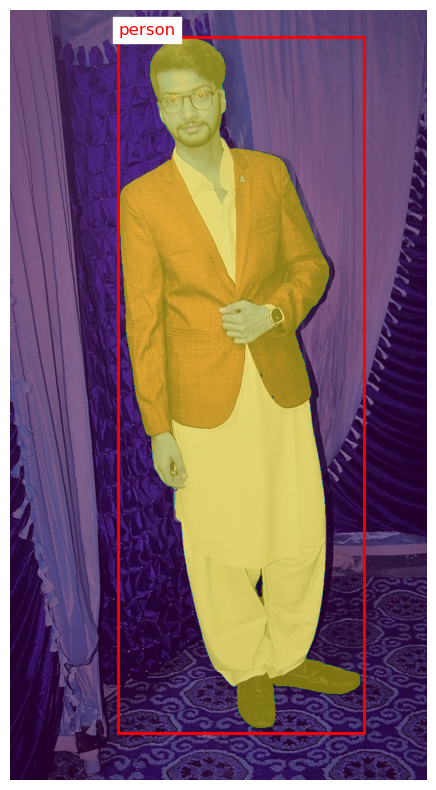

In [32]:
plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

if labels[0] == 0:
  plt.imshow(masks[0], alpha = 0.5)
plt.gca().add_patch(plt.Rectangle((input_box[0],input_box[1]), input_box[2] - input_box[0], input_box[3] - input_box[1],
                                   linewidth = 2, edgecolor = 'r', facecolor='none'))

plt.text(input_box[0], input_box[1] - 5, 'person', fontsize=12, color='r',backgroundcolor='w')
plt.axis('off')
plt.savefig('YoloNAS_SAM/output/' + 'op2.png')
plt.show()